Logs
- [2023/05/14]  
  The first version of this notebook. Please restart this notebook
  if there is a modification to the file `forecast.py`

  We have check the plot of data and it is the same as Figure 10
  and we didn't get the same estimated parameters $\phi_i$
  I have tested using four methods of computation when calculating
  the estimated parameters:
  - scipy.optimize
  - lmfit
  - direct inversion
  - statsmodel AutoReg 

# Example 8.1 - AR(2) model

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import lmfit
import tabulate

sys.path.append(os.path.abspath(os.path.join("..")))

from lib.forecast import Forecast as fcast

from statsmodels.tsa.ar_model import AutoReg

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})


## Load data

### Atron process

In [3]:
filename = "08-table-05-atron-process.ods"

df = fcast.read_ods(filename)

header_names = df.columns.to_list()
process_arr = []
for header in header_names:
  process_arr += df[header].to_list()

process_arr = np.array(process_arr)
process_arr = process_arr[~np.isnan(process_arr)]
df = pd.DataFrame()
df["t"] = np.arange(1, len(process_arr) + 1, dtype=int)
df["Y_t"] = process_arr

df["Y_tM1"] = df["Y_t"].shift(1)
df["Y_tM2"] = df["Y_t"].shift(2)

# display(process_arr)
df

,t,Y_t,Y_tM1,Y_tM2
0,1,60.0,NaN,NaN
1,2,81.0,60.0,NaN
2,3,72.0,81.0,60.0
3,4,78.0,72.0,81.0
4,5,61.5,78.0,72.0
...,...,...,...,...
70,71,90.0,73.5,87.0
71,72,78.0,90.0,73.5
72,73,87.0,78.0,90.0
73,74,99.0,87.0,78.0


### Plot of the data

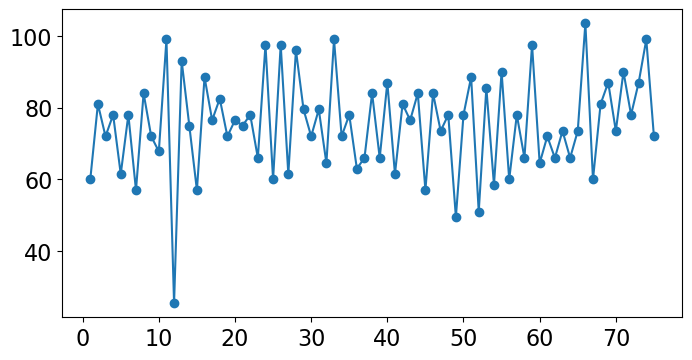

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=6)

plt.show(fig)

## AR(2) model

$$
  Y_t = \phi_0 + \phi_1 Y_{t-1}  + \phi_2 Y_{t-2} + \varepsilon_t
$$

$Y_t$ is the response (dependent) variable at time $t$.    
$Y_{t-1}$, $Y_{t-2}$ are the response variables at time lags $t-1$ and $t-2$
respectively; these $Y$'s play the role of independent variables.    
$\phi_0$, $\phi_1$, $\phi_2$ are the coefficient to be estimated.     
$\varepsilon_t$ is the error term at time $t$, which represents the 
effects of variables not explained by the model; the assumption about
the error term are the same as thos for the standard regression model

In [34]:
df_minitab = df[["Y_t", "Y_tM1", "Y_tM2"]]

from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]

df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab = df_minitab.dropna()
# df_minitab["X_1"].iloc[0] = 60
# df_minitab["X_2"].iloc[:2] = 60 
df_minitab

header: ['Y_t', 'Y_tM1', 'Y_tM2']


,Y,X_1,X_2
2,72.0,81.0,60.0
3,78.0,72.0,81.0
4,61.5,78.0,72.0
5,78.0,61.5,78.0
6,57.0,78.0,61.5
...,...,...,...
70,90.0,73.5,87.0
71,78.0,90.0,73.5
72,87.0,78.0,90.0
73,99.0,87.0,78.0


In [35]:
column_name = ["Y_t", "Y_tM1", "Y_tM2"]
x_regress_arr = [
  [72, 99]]
out_dict = fcast.get_minitab_out(df_minitab, n_vars=len(column_name)-1,
  new_column=column_name, withVIF=False, withCorrMatrix=False, 
  new_observ=1, x_regress=x_regress_arr)

Regression Analysis: Y_t versus Y_tM1, Y_tM2
The regression equation is
Y_t = 114.935 - 0.529 Y_tM1 + 0.005 Y_tM2


Predictor,Coef,SE Coef,t-score,p-value
Constant,114.9353,15.9927,7.19,0.0000
Y_tM1,-0.5289,0.1200,-4.41,0.0000
Y_tM2,0.0049,0.1215,0.04,0.9679


s_yxs = 11.9154   R_sq = 28.3%   R-sq(adj) = 26.2%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,2,3920.5077,1960.2539,13.807,0.0000
Residual error,70,9938.3728,141.9768,,
Total,72,13858.8805,,,


Durbin-Watson Statistics = 1.99
Predicted Values for New Observations


New Obs,Fit,SE Fit,95% CI,95% PI
,,,,
1,77.342,3.054,"(71.250, 83.433)","(52.809, 101.874)"


Values of Predictors for New Observations


New Obs,Y_tM1,Y_tM2
,,
1,72,99


### Forecasting with AR(2)

In [8]:
df_forecast = df_minitab.copy()
df_forecast["t"] = np.arange(3, len(df_forecast)+3, dtype=int)
df_forecast = df_forecast.iloc[-5:]
df_forecast["e_t"] = df_forecast["Y"] - df_forecast["hat_Y"]
df_forecast = df_forecast[["t", "Y", "hat_Y", "e_t"]]
df_forecast["hat_Y"].iloc[0:2] = np.nan
df_forecast["e_t"].iloc[0:2] = np.nan
# display(df_forecast)

x_regress = df_forecast["Y"].iloc[-2:].to_numpy()[::-1]
x_regress = np.hstack((1, x_regress))
# display(x_regress)
phi_params = out_dict["regress"].intercept_, *out_dict["regress"].coef_
Y_regress = x_regress.dot(phi_params)

t_regress = df_forecast["t"].iloc[-1] + 1
# display(t_regress)

data = []
for i, t in enumerate(df_forecast["t"]):
  data.append([
    f"t{i-5:d}", 
    f"{t:d}", 
    f"{df_forecast['Y'].iloc[i]:.1f}",
    "-" if np.isnan(df_forecast["hat_Y"].iloc[i])
      else f"{df_forecast['hat_Y'].iloc[i]:.1f}",
    "-" if np.isnan(df_forecast["e_t"].iloc[i])
      else f"{df_forecast['e_t'].iloc[i]:.1f}"])

data.append(
  [f"t", f"{t_regress:d}", "", f"{Y_regress:.1f}", ""])

# display(data)

table_forecast = tabulate.tabulate(data, tablefmt='html',
  headers=["Period", "Time t", "Values Y_t", "Forecasts hat_Y", "Residuals e_t"],
  colalign=("left", "right", "right", "right", "right"))

display(table_forecast)

Period,Time t,Values Y_t,Forecasts hat_Y,Residuals e_t
t-5,71,90.0,-,-
t-4,72,78.0,-,-
t-3,73,87.0,74.1,12.9
t-2,74,99.0,69.3,29.7
t-1,75,72.0,63.0,9.0
t,76,,77.3,


###  Fitted line plot

In [9]:
df_fit = df_minitab.copy()
df_fit["t"] = np.arange(3, len(df_fit) + 3, dtype=int)
out_dict

{'regress': LinearRegression(),
 'param_stderr': array([15.99271927,  0.12000903,  0.12147549]),
 'param_t_stat': array([ 7.18672748, -4.40700844,  0.04038042]),
 'param_p_vals': array([5.69714538e-10, 3.69630207e-05, 9.67904794e-01]),
 'corr_matrix': array([[-0.53185624,  1.        ],
        [ 0.28969412, -0.53820834]]),
 'R_sq': 0.28288776249529496,
 'dw_stats': 1.9936430593082903,
 'fit': [77.34151347711651],
 'prediction_interval': [[52.80876184023533, 101.87426511399768]]}

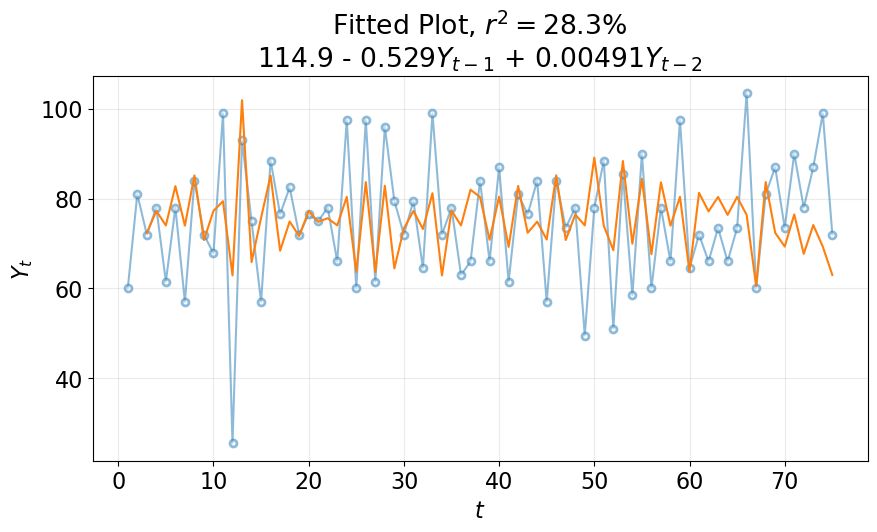

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df["t"], df["Y_t"],
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='-', markeredgewidth=2, alpha=0.5) 

ax.plot(df_fit["t"], df_fit["hat_Y"])

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$Y_t$")

regress_label = r"{:.1f}".format(phi_params[0])
for i, param in enumerate(phi_params[1:]):
  regress_label += r" + ${:.3g}{:s}$".format(param, r"Y_{t-"+f"{i+1}" + "}")  \
    if param > 0 else r" - ${:.3g}{:s}$".format(abs(param), r"Y_{t-"+f"{i+1}" + "}")
ax.set_title(r"Fitted Plot, $r^2={:.1f}$%".format(out_dict["R_sq"]*100)
  + "\n" + regress_label)

ax.grid("on")

plt.show(fig)

### Correlogram plot for $Y_t$ 

In [24]:
df_correlogram = df_minitab.copy()
df_correlogram["t"] = np.arange(3, len(df_correlogram) + 3, dtype=int)
df_correlogram["e_t"] = df_correlogram["Y"] - df_correlogram["hat_Y"]
df_correlogram

,Y,X_1,X_2,hat_Y,t,e_t
2,72.0,81.0,60.0,72.390282,3,-0.390282
3,78.0,72.0,81.0,77.253219,4,0.746781
4,61.5,78.0,72.0,74.035787,5,-12.535787
5,78.0,61.5,78.0,82.791752,6,-4.791752
6,57.0,78.0,61.5,73.984282,7,-16.984282
...,...,...,...,...,...,...
70,90.0,73.5,87.0,76.489329,71,13.510671
71,78.0,90.0,73.5,67.696575,72,10.303425
72,87.0,78.0,90.0,74.124081,73,12.875919
73,99.0,87.0,78.0,69.305291,74,29.694709


In [56]:
num_of_rk = 10
df_acorr_analysis = fcast.get_correlogram(df_correlogram, num_of_rk, 
  columns=["t", "Y"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.530854,-4.535619,21.429001,-0.233317,0.233317
1,2,0.281586,1.924012,27.543310,-0.291750,0.291750
2,3,-0.030276,-0.197112,27.615002,-0.306188,0.306188
3,4,-0.007979,-0.051922,27.620054,-0.306351,0.306351
4,5,0.157105,1.022268,29.607328,-0.306362,0.306362
5,6,-0.163280,-1.047555,31.785919,-0.310717,0.310717
6,7,0.160778,1.016334,33.930246,-0.315353,0.315353
7,8,-0.036651,-0.228474,34.043393,-0.319784,0.319784
8,9,0.051024,0.317844,34.266108,-0.320013,0.320013
9,10,-0.106449,-0.662188,35.250854,-0.320455,0.320455


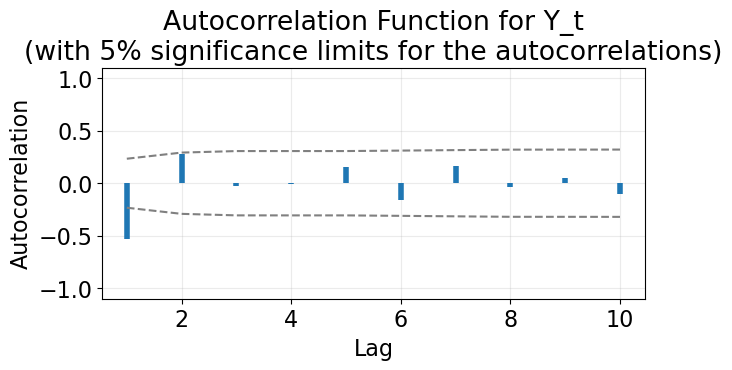

In [58]:
fcast.plot_autocorr_func(df_acorr_analysis, title=r"Y_t")

## Compute the estimated parameters using `lmfit`

In [ ]:
def residual_func(params, Y, X_1, X_2):
  phi0 = params["phi0"].value
  phi1 = params["phi1"].value
  phi2 = params["phi2"].value

  y_model = phi0 + phi1*X_1 + phi2*X_2
  return Y - y_model

In [ ]:
params = lmfit.Parameters()
params.add("phi0", 100)
params.add("phi1", -0.5)
params.add("phi2", 0.001)

x1_data = df_minitab["X_1"]
x2_data = df_minitab["X_2"]
y_data = df_minitab["Y"]

ol = lmfit.minimize(residual_func, params, args=(y_data, x1_data, x2_data),
  method="leastsq", ftol=1e-20)

ol

## Direct inversion

From "The Yule Walker Equations for the AR Coefficients" by Gidon Eshel

In [38]:
Y_t = df["Y_t"].to_numpy()
Y_t

array([ 60. ,  81. ,  72. ,  78. ,  61.5,  78. ,  57. ,  84. ,  72. ,
        67.8,  99. ,  25.5,  93. ,  75. ,  57. ,  88.5,  76.5,  82.5,
        72. ,  76.5,  75. ,  78. ,  66. ,  97.5,  60. ,  97.5,  61.5,
        96. ,  79.5,  72. ,  79.5,  64.5,  99. ,  72. ,  78. ,  63. ,
        66. ,  84. ,  66. ,  87. ,  61.5,  81. ,  76.5,  84. ,  57. ,
        84. ,  73.5,  78. ,  49.5,  78. ,  88.5,  51. ,  85.5,  58.5,
        90. ,  60. ,  78. ,  66. ,  97.5,  64.5,  72. ,  66. ,  73.5,
        66. ,  73.5, 103.5,  60. ,  81. ,  87. ,  73.5,  90. ,  78. ,
        87. ,  99. ,  72. ])

In [55]:
b = np.expand_dims(Y_t[2:], axis=1)
#display(b)
A = np.vstack((np.ones(len(Y_t[1:-1])), Y_t[1:-1], Y_t[:-2])).transpose()

phi = np.linalg.inv(A.transpose().dot(A)).dot(A.transpose()).dot(b)
phi

array([[ 1.14935315e+02],
       [-5.28880827e-01],
       [ 4.90523095e-03]])

## Using `statsmodels`

In [68]:
model = AutoReg(Y_t, lags=2, old_names=False)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   75
Model:                     AutoReg(2)   Log Likelihood                -282.933
Method:               Conditional MLE   S.D. of innovations             11.668
Date:                Sun, 14 May 2023   AIC                            573.865
Time:                        16:26:10   BIC                            583.027
Sample:                             2   HQIC                           577.516
                                   75                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9353     15.661      7.339      0.000      84.241     145.630
y.L1          -0.5289      0.118     -4.500      0.000      -0.759      -0.299
y.L2           0.0049      0.119      0.041      0.9